## Decision Tree

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [3]:
outputVar = 'Risk'

X_train = train.drop(columns= [outputVar],axis=1)
y_train = train[outputVar]

X_test = test.drop(columns= [outputVar],axis=1)
y_test = test[outputVar]

### Vanilla Performance

In [4]:
from sklearn.tree import DecisionTreeClassifier

decTree = DecisionTreeClassifier(random_state=0)
_ = decTree.fit(X_train, y_train)

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

myCV = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
myScore = cross_val_score(decTree, X_train, y_train, scoring = 'roc_auc', cv = myCV).mean()

print('The cross-validation-score of this classifier is ' +
      str(myScore) + 
      ' (training set).\n')

The cross-validation-score of this classifier is 0.6381201298701298 (training set).



In [6]:
from sklearn.metrics import roc_auc_score

y_pred = decTree.predict(X_test)

myScore = roc_auc_score(y_test, y_pred)

print('The cross-validation-score of this classifier is ' +
      str(myScore) + 
      ' (testing set).\n')

The cross-validation-score of this classifier is 0.6056338028169015 (testing set).



### Optimization

In [7]:
import skopt

The parameter tuning algorithm we are utilizing is called 'Bayesian Hyperparameter Optimization'. 

This algorithm firstly randomly picks combinations of parameters and then evaluates the score of the classifier with the given parameters - in our case, the score will be the ROC AUC. Then, based on the given scores, an approximation of the objective function is created. The objective function takes the parameters of the model as an input, and returns the classifier performance as an output. Our estimation of this function is called 'posterior function'.

This posterior function is updated iteratively by sampling new combinations of parameters. These are chosen using an 'acquisition function' which calculates areas of uncertainty in the posterior function. Here,  exploration and exploitation of the objective function are balanced. This means that combinations of parameters are sampled globally, to understand the overall shape of the objective function, but also locally at points of interest, to find the exact parameters that give the best result.

After a given number of samples, the best parameters according to the updated posterior function are returned.

In [8]:
from skopt.space import Integer, Categorical, Real
num_features = len(X_train.columns)
space = [Integer(1, 4,name='max_depth'),
        Integer(1, 200, name='min_samples_leaf'),
        Integer(2, 200, name='min_samples_split'),
        Categorical([None, 'balanced'], name='class_weight'),
        Real(0.0, 1, name='ccp_alpha')
]

In [9]:
from skopt.utils import use_named_args

myRandom = 0
@use_named_args(space)
def objective(**params):
  tempTree = DecisionTreeClassifier(**params, random_state = 0)
  global myRandom
  # Make 10 stratified shuffled folds using our random seed.
  myCV = StratifiedKFold(n_splits=10, shuffle=True, random_state=myRandom)
  # Score the tree
  scores = cross_val_score(tempTree, X_train, y_train, scoring = 'roc_auc', cv = myCV)
  # Update the random seed.
  myRandom = myRandom + 1
  result = scores.mean()
  # The optimization algorithm minimizes the score, so we have to negate it.
  return -result

In [10]:
from skopt import gp_minimize

opt = gp_minimize(objective, space, n_calls=400, random_state=0, verbose = False, n_jobs = -1)

These are our optimal hyperparameters:

In [11]:
opt.x

[4, 73, 2, None, 0.0]

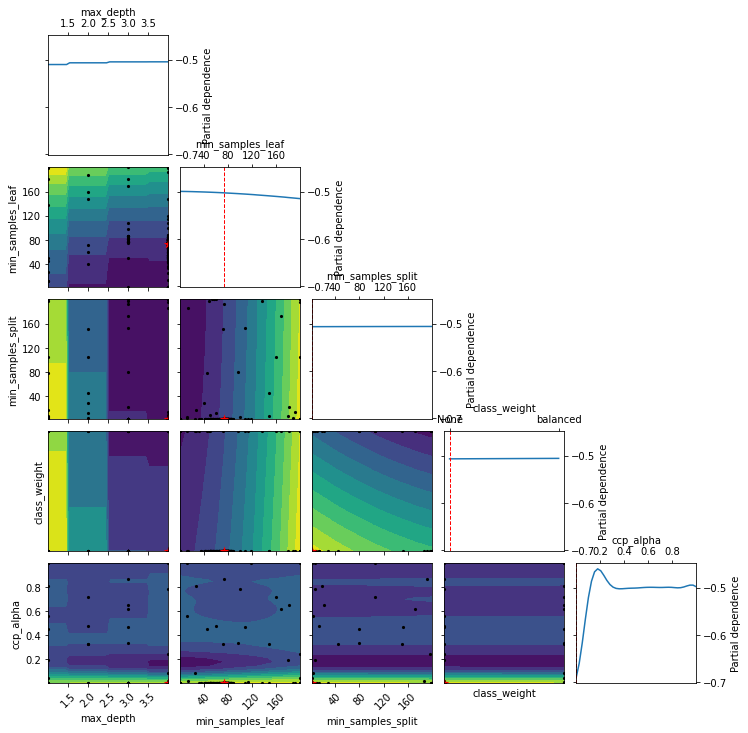

In [12]:
from skopt.plots import plot_objective

_ = plot_objective(opt)

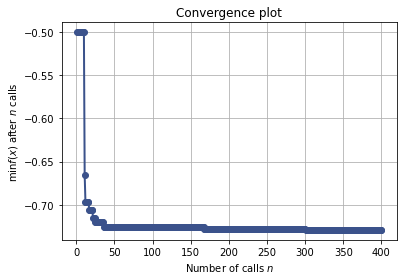

In [13]:
from skopt.plots import plot_convergence

_ = plot_convergence(opt)

Let's now create the tree with the given hyperparameters:

In [14]:
optTree = DecisionTreeClassifier(max_depth = opt.x[0],
                                 min_samples_leaf = opt.x[1],
                                 min_samples_split = opt.x[2],
                                 class_weight = opt.x[3],
                                 ccp_alpha = opt.x[4],
                                 random_state = 0
                                 )

_ = optTree.fit(X_train, y_train)

In [15]:
myCV = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
myScore = cross_val_score(optTree, X_train, y_train, scoring = 'roc_auc', cv = myCV).mean()

print('The cross-validation-score of this classifier is ' +
      str(myScore) + 
      ' (training set).\n')

The cross-validation-score of this classifier is 0.725761607142857 (training set).



In [16]:
y_pred = optTree.predict(X_test)

myScore = roc_auc_score(y_test, y_pred)

print('The cross-validation-score of this classifier is ' +
      str(myScore) + 
      ' (testing set).\n')

The cross-validation-score of this classifier is 0.6153472559494901 (testing set).



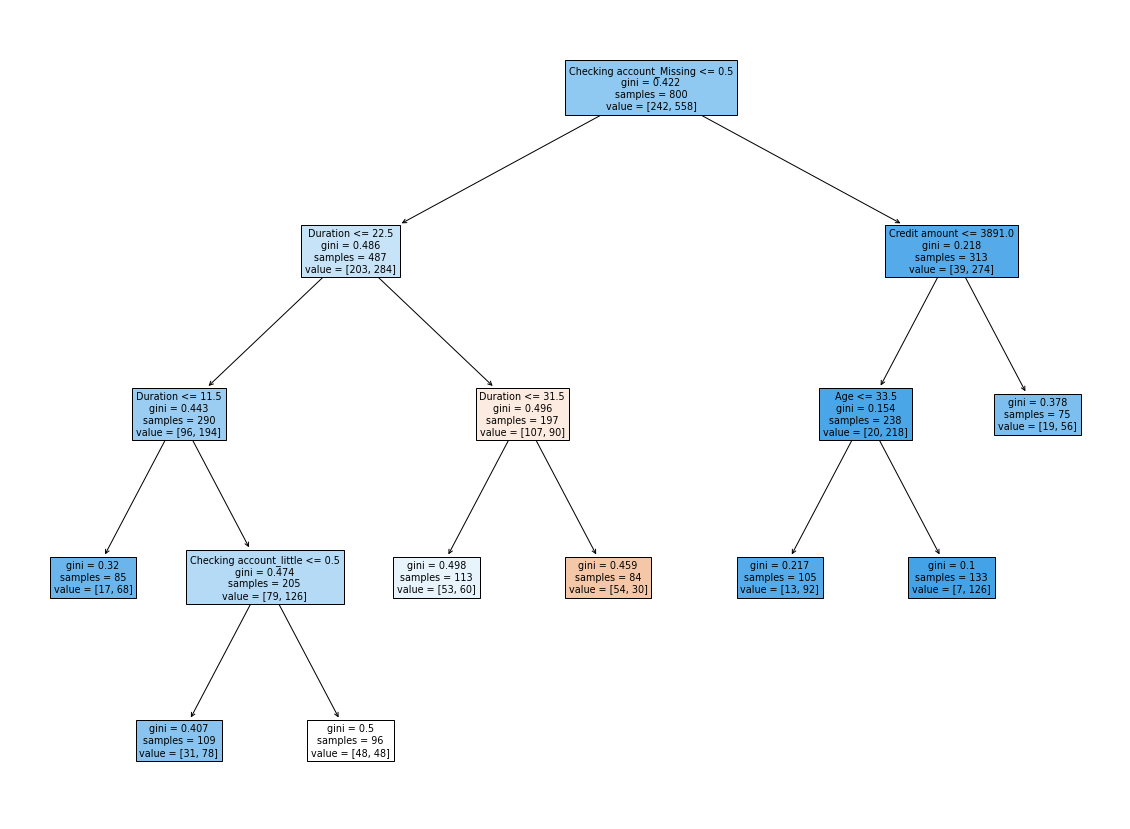

In [17]:
from sklearn import tree

fig = plt.figure(figsize=(20, 15))
_ = tree.plot_tree(optTree,
                   feature_names = X_train.keys(),
                   filled=True)
